In [66]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
print(df.head())  # First 5 rows
print(df.info())  # Data types, missing values
print(df['stroke'].value_counts())  # Check imbalance

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

In [67]:
df = df.drop('id', axis=1)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
# Check for missing values
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


<h1>Step 2 EDA</h1>

<h4>Goal: Understand the data’s patterns to inform feature engineering and modeling. We’ll look at key features (age, avg_glucose_level, hypertension, etc.) and their relationship with stroke.</h4>


In [68]:
print(df.describe())

               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  5110.000000  5110.000000  
mean     28.862035     0.048728  
std       7.699562     0.215320  
min      10.300000     0.000000  
25%      23.800000     0.000000  
50%      28.100000     0.000000  
75%      32.800000     0.000000  
max      97.600000     1.000000  


               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  5110.000000  5110.000000  
mean     28.862035     0.048728  
std       7.699562     0.215320  
min      10.300000     0.000000  
25%      23.800000     0.000000  
50%      28.100000     0.000000  
75%      32.800000     0.000000  
max      97.600000     1.000000  


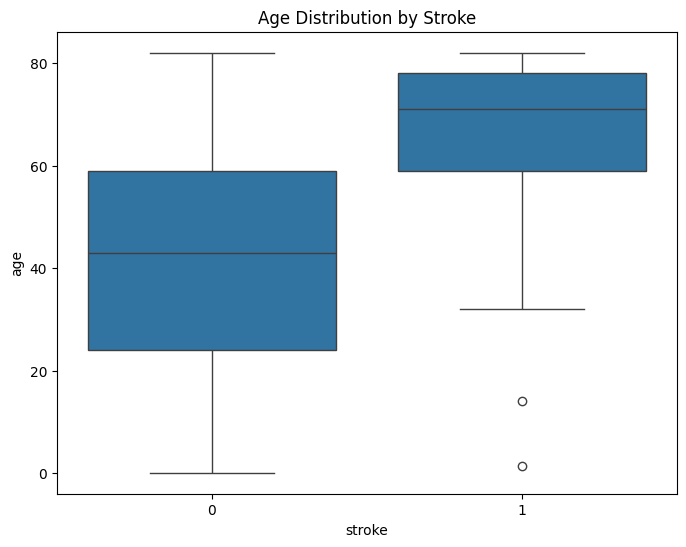

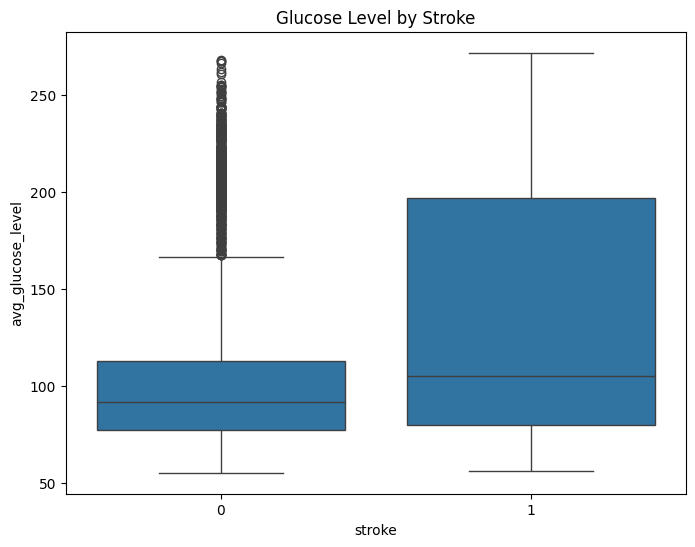

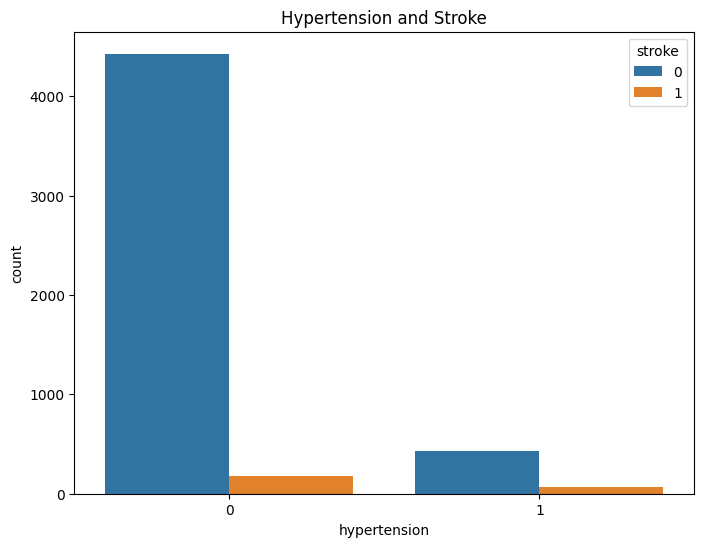

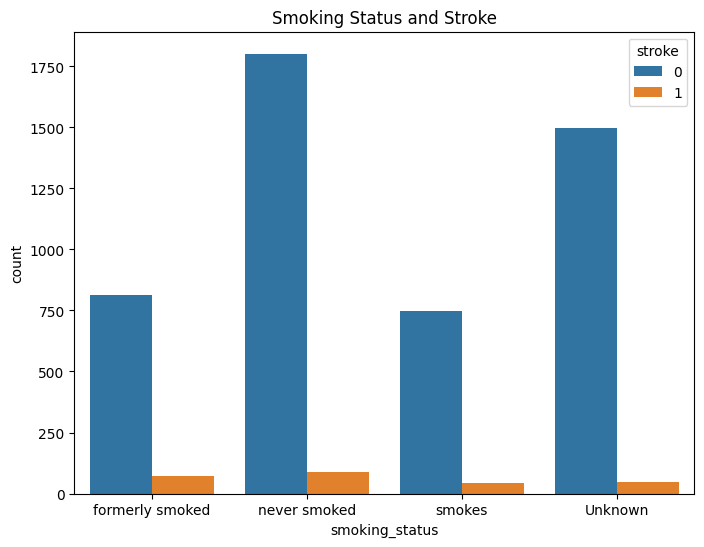

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary stats
print(df.describe())

# Age vs. Stroke
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke')
plt.show()

# Glucose vs. Stroke
plt.figure(figsize=(8, 6))
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Glucose Level by Stroke')
plt.show()

# Hypertension vs. Stroke
plt.figure(figsize=(8, 6))
sns.countplot(x='hypertension', hue='stroke', data=df)
plt.title('Hypertension and Stroke')
plt.show()

# Smoking Status vs. Stroke
plt.figure(figsize=(8, 6))
sns.countplot(x='smoking_status', hue='stroke', data=df)
plt.title('Smoking Status and Stroke')
plt.show()

In [70]:
# Interaction term: Age * Glucose
df['age_glucose'] = df['age'] * df['avg_glucose_level']

# Age risk categories
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 100], labels=['low', 'medium', 'high'])

# Comorbidity (hypertension + heart disease)
df['comorbidity'] = df['hypertension'] + df['heart_disease']

# Smoking intensity
df['smoking_score'] = df['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 0})

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'age_group']:
    df[col] = le.fit_transform(df[col])

# Verify
print(df[['age_glucose', 'age_group', 'comorbidity', 'smoking_score']].head())
print(df.dtypes)

   age_glucose  age_group  comorbidity  smoking_score
0     15322.23          0            1              1
1     12334.81          0            0              0
2      8473.60          0            1              0
3      8390.27          2            0              2
4     13755.48          0            1              0
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
age_glucose          float64
age_group              int64
comorbidity            int64
smoking_score          int64
dtype: object


<h1>Goal: Train an XGBoost model to predict stroke, handle the imbalance, and use SHAP to explain predictions.</h1>

so first the xgboost algo will ensure to penalise the true negative by the ratio of non-stroke to stroke data
By setting scale_pos_weight, XGBoost gives more importance to the minority class (stroke=1) during training. This helps the model focus on correctly predicting stroke cases, improving recall (the ability to catch true positives) even if the dataset is imbalanced.

Since dataset is imbalanced, accuracy isn’t a good metric (a model predicting “no stroke” for all cases would get 95% accuracy but fail at identifying strokes). F1-score and ROC-AUC are better for imbalanced data.

The F1-score is the harmonic mean of precision and recall, focusing on the model’s performance on the positive class (stroke=1).

Precision = True Positives (TP) / (True Positives + False Positives)
Recall = True Positives (TP) / (True Positives + False Negatives)

F1 = 2 * (Precision * Recall) / (Precision + Recall) ------ (0,1) 1 is perfect and 0 is terrible

In a medical context, missing a stroke case (false negative) is worse than a false alarm (false positive). F1-score ensures we’re not sacrificing recall for precision.



In [71]:
# Drop smoking_status
df = df.drop('smoking_status', axis=1)
# Features (X) and target (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

In [72]:

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
import xgboost as xgb
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # ~20
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import f1_score, roc_auc_score
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))



F1 Score: 0.2391304347826087
ROC-AUC Score: 0.8112962962962963


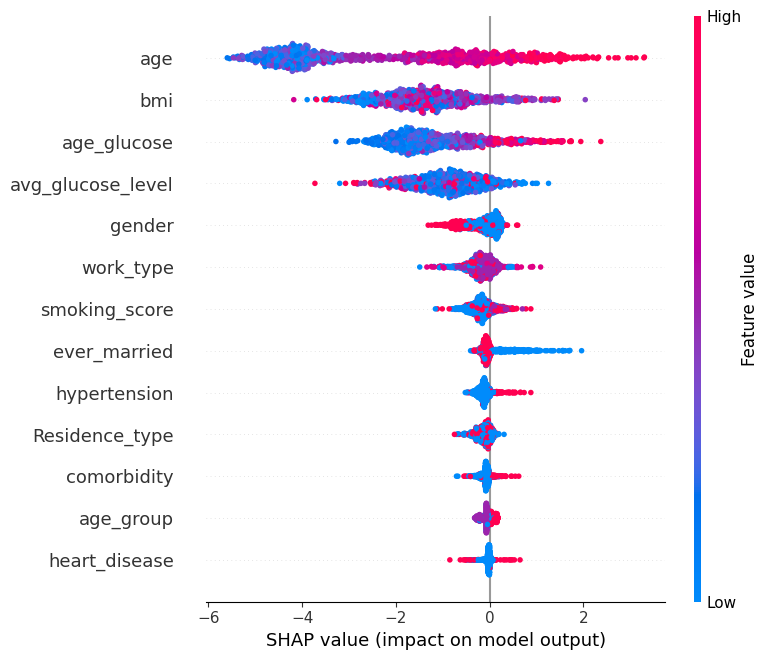

In [73]:
# SHAP explanation
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [74]:
# # Force plot for first test sample
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The F1-score (0.2391) is quite low. Since F1 is the harmonic mean of precision and recall for the positive class (stroke=1), this suggests the model struggles with either precision, recall, or both.

Likely scenario: The model might have high recall (catching many stroke cases due to scale_pos_weight) but low precision (many false positives), dragging down the F1-score.



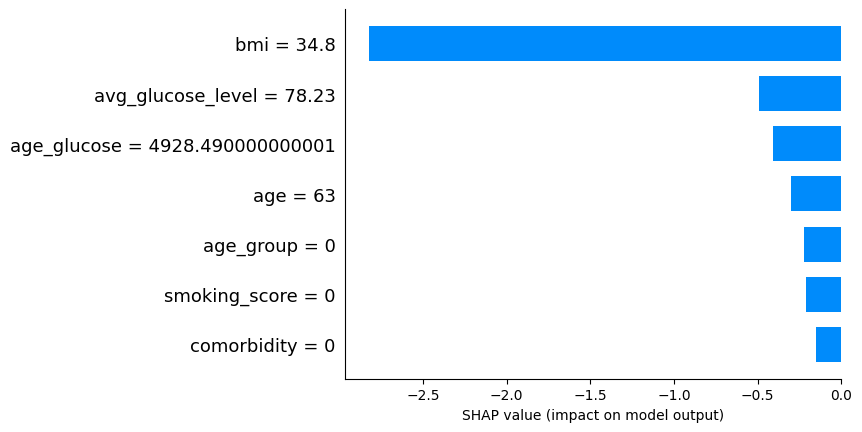

In [75]:
shap.bar_plot(shap_values[0], X_test.iloc[0,:])

In [76]:
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Precision: 0.2619047619047619
Recall: 0.22


Manual selection of threshold for increasing f1 score

In [83]:
# Test a manual threshold (e.g., 0.05)
manual_threshold = 0.05
y_pred_manual = (y_pred_proba >= manual_threshold).astype(int)
print("F1 Score at threshold 0.05:", f1_score(y_test, y_pred_manual))
print("Precision at threshold 0.05:", precision_score(y_test, y_pred_manual))
print("Recall at threshold 0.05:", recall_score(y_test, y_pred_manual))

F1 Score at threshold 0.05: 0.2711864406779661
Precision at threshold 0.05: 0.17204301075268819
Recall at threshold 0.05: 0.64


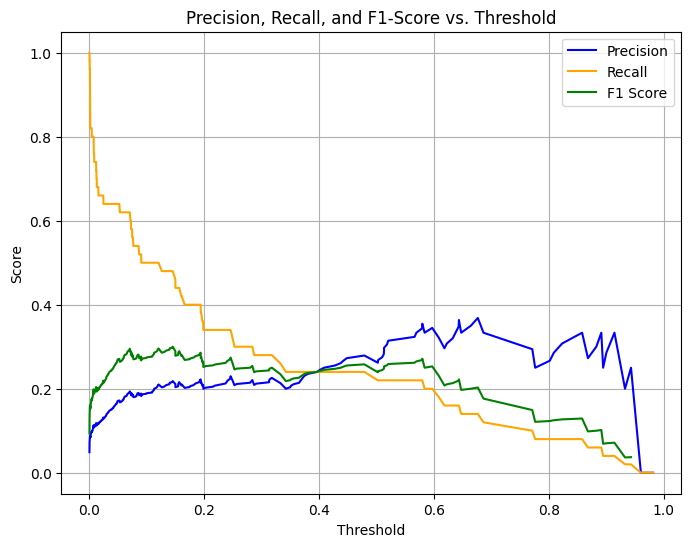

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

In [79]:
# import xgboost as xgb
# from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# # Try scale_pos_weight = 15
# model = xgb.XGBClassifier(scale_pos_weight=15, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
# print("F1 Score (scale_pos_weight=15):", f1_score(y_test, y_pred))
# print("Precision (scale_pos_weight=15):", precision_score(y_test, y_pred))
# print("Recall (scale_pos_weight=15):", recall_score(y_test, y_pred))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

<h1>Lets use SMOTE X didn't work X</h1> 

In [80]:
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import f1_score, roc_auc_score

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# # Train model without scale_pos_weight (SMOTE balances classes)
# model = xgb.XGBClassifier(random_state=42)
# model.fit(X_train_smote, y_train_smote)
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
# print("F1 Score (SMOTE):", f1_score(y_test, y_pred))
# print("Precision (SMOTE):", precision_score(y_test, y_pred))
# print("Recall (SMOTE):", recall_score(y_test, y_pred))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

In [81]:
# Assuming y_pred_proba is from the original model (scale_pos_weight=20)
thresholds_to_try = [0.03, 0.04, 0.05, 0.06, 0.07]
for thresh in thresholds_to_try:
    y_pred_new = (y_pred_proba >= thresh).astype(int)
    print(f"Threshold {thresh}:")
    print("F1 Score:", f1_score(y_test, y_pred_new))
    print("Precision:", precision_score(y_test, y_pred_new))
    print("Recall:", recall_score(y_test, y_pred_new))
    print()

Threshold 0.03:
F1 Score: 0.2302158273381295
Precision: 0.14035087719298245
Recall: 0.64

Threshold 0.04:
F1 Score: 0.2471042471042471
Precision: 0.15311004784688995
Recall: 0.64

Threshold 0.05:
F1 Score: 0.2711864406779661
Precision: 0.17204301075268819
Recall: 0.64

Threshold 0.06:
F1 Score: 0.2767857142857143
Precision: 0.1781609195402299
Recall: 0.62

Threshold 0.07:
F1 Score: 0.29523809523809524
Precision: 0.19375
Recall: 0.62



okay so we have a model which assigns probability based on the characteristics and we can define the threshold to assign the risk class. 

In [82]:
import numpy as np

# Assuming y_pred_proba is from your best model (scale_pos_weight=20)
# Define risk categories based on probability thresholds
def assign_risk_score(prob):
    if prob < 0.07:
        return "Low Risk"
    elif 0.07 <= prob <= 0.15:
        return "Medium Risk"
    else:
        return "High Risk"

# Apply the risk scoring to the test set
risk_scores = [assign_risk_score(prob) for prob in y_pred_proba]

# Add risk scores to your test set (assuming X_test has the features)
import pandas as pd
results_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'Predicted Stroke': (y_pred_proba >= 0.07).astype(int),
    'Actual Stroke': y_test,
    'Risk Category': risk_scores
})

# Display the first few rows
print(results_df.head())

# Summary of risk categories
print("\nRisk Category Distribution:")
print(results_df['Risk Category'].value_counts())

      Probability  Predicted Stroke  Actual Stroke Risk Category
3725     0.006757                 0              0      Low Risk
4481     0.000252                 0              0      Low Risk
1545     0.000003                 0              0      Low Risk
1820     0.000039                 0              0      Low Risk
1262     0.010054                 0              0      Low Risk

Risk Category Distribution:
Risk Category
Low Risk       862
High Risk      107
Medium Risk     53
Name: count, dtype: int64


In [84]:
import joblib

# Save the model
joblib.dump(model, 'stroke_prediction_model.pkl')

# Save the threshold (optional, for reference)
with open('best_threshold.txt', 'w') as f:
    f.write(str(0.07))

              Feature  Importance
1              gender    0.276592
4        ever_married    0.076275
8                 bmi    0.074347
11        comorbidity    0.073494
9       smoking_score    0.072743
5           work_type    0.065219
7   avg_glucose_level    0.060686
2        hypertension    0.053568
0                 age    0.052749
10        age_glucose    0.052388
6      Residence_type    0.048821
3       heart_disease    0.048362
12          age_group    0.044758


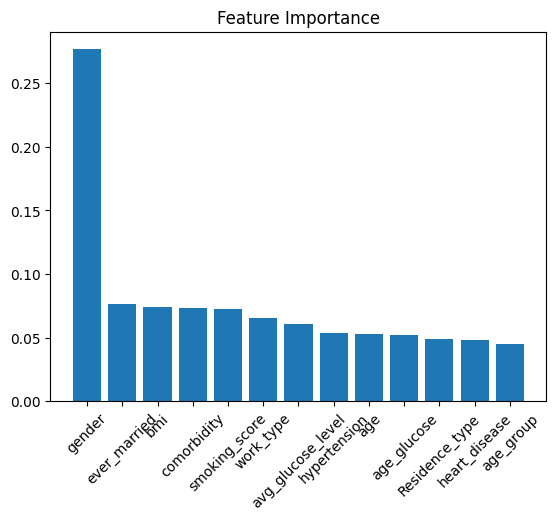

In [85]:
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
feature_names = ["age", "gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "avg_glucose_level", "bmi", "smoking_score", "age_glucose", "comorbidity", "age_group"]
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df)
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.show()